In [8]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os.path as path
import seaborn as sns
import scipy.stats as stats

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Bidirectional, BatchNormalization, Conv1D, MaxPooling1D, Reshape
import tensorflow_decision_forests as tfdf

In [7]:
ROOT_DIR = path.abspath("../../data/datasets")

def csvfile(root_dir, train):
    # UNSW_NB15_testing-set.csv is actually more suitable for training because it has more data
    return path.join(root_dir, "UNSW_NB15_" + ("testing" if train else "training") + "-set.csv")

train = pd.read_csv(csvfile(ROOT_DIR, True))
test = pd.read_csv(csvfile(ROOT_DIR, False))

## Config

In [12]:
NUM_CLIENTS = 3
NUM_ROUNDS = 30
S_ADDR = "127.0.0.1:8080"
DEBUG = 0
LOCAL_DEBUG = False
TEST_CENTRALISED = 0
MODEL_CKPT_DIR=path.abspath("../../model_ckpt/")
RUNS = 10

## Global Vars

In [9]:
histories = []

## Start to Preprocess

In [10]:
list_drop = ['id', 'attack_cat']
train = train.drop(list_drop, axis=1)
test = test.drop(list_drop, axis=1)

In [11]:
df = pd.concat([train, test])
df.describe(include='all')

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,257673.000000,257673,257673,257673,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
unique,NaN,133,13,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,123041,141321,117164,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.246715,NaN,NaN,NaN,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,...,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,0.639077
std,5.974305,NaN,NaN,NaN,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,...,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,0.480269
min,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,0.004285,NaN,NaN,NaN,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,0.685777,NaN,NaN,NaN,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,...,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,1.000000


In [12]:
df['proto'].unique()

array(['tcp', 'udp', 'arp', 'ospf', 'icmp', 'igmp', 'rtp', 'ddp',
       'ipv6-frag', 'cftp', 'wsn', 'pvp', 'wb-expak', 'mtp', 'pri-enc',
       'sat-mon', 'cphb', 'sun-nd', 'iso-ip', 'xtp', 'il', 'unas',
       'mfe-nsp', '3pc', 'ipv6-route', 'idrp', 'bna', 'swipe',
       'kryptolan', 'cpnx', 'rsvp', 'wb-mon', 'vmtp', 'ib', 'dgp',
       'eigrp', 'ax.25', 'gmtp', 'pnni', 'sep', 'pgm', 'idpr-cmtp',
       'zero', 'rvd', 'mobile', 'narp', 'fc', 'pipe', 'ipcomp', 'ipv6-no',
       'sat-expak', 'ipv6-opts', 'snp', 'ipcv', 'br-sat-mon', 'ttp',
       'tcf', 'nsfnet-igp', 'sprite-rpc', 'aes-sp3-d', 'sccopmce', 'sctp',
       'qnx', 'scps', 'etherip', 'aris', 'pim', 'compaq-peer', 'vrrp',
       'iatp', 'stp', 'l2tp', 'srp', 'sm', 'isis', 'smp', 'fire', 'ptp',
       'crtp', 'sps', 'merit-inp', 'idpr', 'skip', 'any', 'larp', 'ipip',
       'micp', 'encap', 'ifmp', 'tp++', 'a/n', 'ipv6', 'i-nlsp',
       'ipx-n-ip', 'sdrp', 'tlsp', 'gre', 'mhrp', 'ddx', 'ippc', 'visa',
       'secure-vmtp', 

### Data Visualisation

In [13]:
import matplotlib.pyplot as plt

df_num = df.select_dtypes(include=[np.number])
df_num = df_num.loc[:, (df_num.nunique() > 2)]
df_num.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst
count,257673.000000,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,1.246715,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,6.582143e+05,...,1.324978,6.050467,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049
std,5.974305,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,2.412372e+06,...,0.992300,8.173749,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,0.000000e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000
50%,0.004285,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,1.747441e+03,...,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000
75%,0.685777,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,2.210538e+04,...,2.000000,6.000000,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,...,6.000000,59.000000,59.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000


In [14]:
max_b = np.amax(df_num)
max_b

5988000256.0

## Removing outliers

In [15]:
# Select numeric categories
def rm_outliers(df_in: pd.DataFrame):
    result= df_in.copy()
    df_numeric = df_in.select_dtypes(include=[np.number])

    # Remove outliers
    for feature in df_numeric.columns:
        if DEBUG == 1:
            print(feature)
            print('max = '+str(df_numeric[feature].max()))
            print('75th = '+str(df_numeric[feature].quantile(0.95)))
            print('median = '+str(df_numeric[feature].median()))
            print(df_numeric[feature].max()>10*df_numeric[feature].median())
            print('----------------------------------------------------')
        result[feature] = np.where(df_in[feature] < df_in[feature].quantile(0.95), df_in[feature], df_in[feature].quantile(0.95))
    return result

## Other unused pruning

In [16]:

# # Apply log to features > 50 unique values.

def logarithm(df_in: pd.DataFrame):
    df_numeric = df_in.select_dtypes(include=[np.number])
    for feature in df_numeric.columns:
        if df_numeric[feature].nunique()>50:
            if df_numeric[feature].min()==0:
                df_in[feature] = np.log(df[feature]+1)
            else:
                df_in[feature] = np.log(df[feature])
    return df_in
    

# Reduce labels of categorical features
def reduce_labels(df_in: pd.DataFrame):
    df_cat = df_in.select_dtypes(exclude=[np.number])
    for feature in df_cat.columns:
        if DEBUG == 1:
            print(feature)
            print('nunique = '+str(df_cat[feature].nunique()))
            print(df_cat[feature].nunique()>6)
            print(df_in[feature].value_counts().head().index)
            print(sum(df_in[feature].isin(df_in[feature].value_counts().head().index)))
            print('----------------------------------------------------')
        
        if df_cat[feature].nunique()>6:
            df_in[feature] = np.where(df_in[feature].isin(df_in[feature].value_counts().head().index), df_in[feature], '-')
    return df_in


## Encoding and Normalisations

In [17]:
#One-hot encoding
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(each, axis=1)
    return df


In [18]:
# Normalise
# Function to min-max normalize
def normalize(df_in: pd.DataFrame, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df_in.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df_in[feature_name].astype('float').max()
        min_value = df_in[feature_name].astype('float').min()
        if max_value > min_value:
            result[feature_name] = (df_in[feature_name].astype('float') - min_value) / (max_value - min_value)
    return result

In [19]:
outlier_r_df = rm_outliers(df_num)
max_a = np.amax(outlier_r_df)
max_a

3835955544.2

Text(1200000001.0, 50000, 'Median: 1.0')

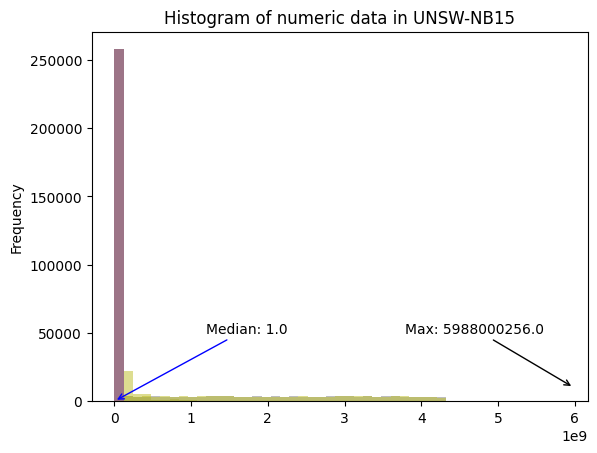

In [20]:
plt.figure()
plt.title("Histogram of numeric data in UNSW-NB15")
for feature in df_num:
    df_num[feature].plot.hist(bins=range(0,int(max_b),120_000_000), alpha=0.5)

plt.annotate(f'Max: {max_b}', xy=(max_b, 10000), xytext=(max_b-2_200_000_000, 50000), arrowprops=dict(arrowstyle='->', lw=1))
plt.annotate(f'Median: {np.median(df_num)}', xy=(np.median(df_num), 1), xytext=(np.median(df_num)+1_200_000_000, 50000), arrowprops=dict(arrowstyle='->', lw=1, color='blue'))

# axes[1].set_title("Distribution after removing outliers")
# for feature in new_df.select_dtypes(include=[np.number]):
#     outlier_r_df[feature].plot.hist(bins=range(0,int(max_a),60_000_000), alpha=0.5, ax=axes[1])

In [21]:
# fig, axes = plt.subplots(1,2, figsize=(15,7))

# axes[0].set_title("Distribution of numeric data in UNSW-NB15")
# for feature in df_num:
#     df_num[feature].plot.hist(bins=range(0,int(max_b),120_000_000), alpha=0.5, ax=axes[0])

# axes[1].set_title("Distribution after applying logarithm")
# for feature in logged_df.select_dtypes(include=[np.number]):
#     logged_df[feature].plot.hist(bins=range(0,int(max_a),3), alpha=0.5, ax=axes[1])

In [22]:
norm = normalize(outlier_r_df, outlier_r_df.columns)
max_a = np.amax(norm)
max_a

1.0

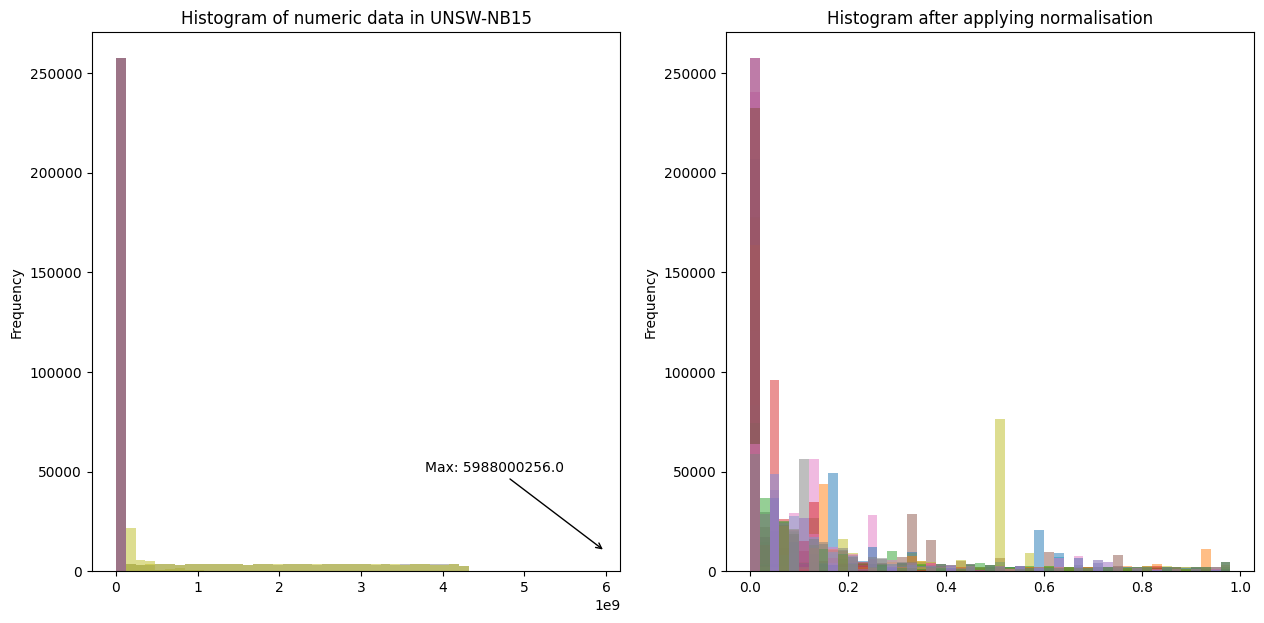

In [23]:
fig, axes = plt.subplots(1,2, figsize=(15,7))

axes[0].set_title("Histogram of numeric data in UNSW-NB15")
for feature in df_num:
    df_num[feature].plot.hist(bins=range(0,int(max_b),120_000_000), alpha=0.5, ax=axes[0])
axes[0].annotate(f'Max: {max_b}', xy=(max_b, 10000), xytext=(max_b-2_200_000_000, 50000), arrowprops=dict(arrowstyle='->', lw=1))

axes[1].set_title("Histogram after applying normalisation")
for feature in norm.select_dtypes(include=[np.number]):
    norm[feature].plot.hist(bins=np.arange(0, 1, 0.02), alpha=0.5, ax=axes[1])

In [24]:
def preprocess(df_in: pd.DataFrame):
    df_in = rm_outliers(df_in)
    df_in = normalize(df_in, df_in.select_dtypes(include=[np.number]).columns)
    return one_hot(df_in, ['proto', 'service', 'state'])

new_train_df = preprocess(df)

In [25]:
print(new_train_df.shape)

(257673, 197)


## Resulting DataFrame

In [26]:
def partition(num_clients: int, cid: int, df: pd.DataFrame, split: bool = False, ):
    part = get_part(num_clients, cid, df)
    y = part['label']
    X = part.drop(['label'], axis=1)
    return train_test_split(X, y, random_state=42, test_size=0.2, stratify=y) if split else (X, y)

def get_part(num_clients: int, cid: int, df: pd.DataFrame | np.ndarray):
    n = len(df)
    offset = int(n * 0.25) # Data will have a 25% offset from start and 
    start = (cid - 1) * offset
    end = n - (offset * int(num_clients - cid))
    return df.iloc[start:, :] if cid == num_clients else df.iloc[start:end, :]

In [27]:
np.shape(new_train_df), np.shape(get_part(NUM_CLIENTS, 1, new_train_df))

((257673, 197), (128837, 197))

In [28]:
print("Percentage of partition over total: {:.2f}%".format(np.shape(get_part(NUM_CLIENTS, 1, new_train_df))[0]*100/np.shape(new_train_df)[0]))

Percentage of partition over total: 50.00%


## K-Fold validation

In [29]:
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')

# kfold = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)
# kfold.get_n_splits(X_train, y_train)

## Model

In [30]:
from keras.metrics import SensitivityAtSpecificity, SpecificityAtSensitivity
from keras.optimizers import Adam

def get_big_model():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=64, padding="same",activation="relu",input_shape=(196, 1)))
    model.add(MaxPooling1D(pool_size=(10)))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Reshape((128, 1), input_shape = (128, )))
    model.add(MaxPooling1D(pool_size=(5)))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(128, return_sequences=False)))
    model.add(Dropout(0.6))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', SensitivityAtSpecificity(0.5), SpecificityAtSensitivity(0.5)])
    return model

def get_med_cnn(input_shape=(196, 1)):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=64, padding='same', activation='relu', input_shape=input_shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.6))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy', SensitivityAtSpecificity(0.5, name="Sensitivity"), SpecificityAtSensitivity(0.5, name="Specificity")])
    return model

def get_simple_lstm():
    model = Sequential()
    model.add(Bidirectional(LSTM(30, return_sequences=True), input_shape=(1, 196)))
    model.add(Bidirectional(LSTM(30, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', SensitivityAtSpecificity(0.5, name="Sensitivity"), SpecificityAtSensitivity(0.5, name="Specificity")])
    return model

def get_random_forest_tree(tuner_param=None):
    model = tfdf.keras.RandomForestModel(tuner=tuner_param)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [31]:
get_simple_lstm().summary()

2023-08-27 21:07:14.325574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 21:07:14.540757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 21:07:14.540825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 21:07:14.542867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 21:07:14.542929: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 60)             54480     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 60)                21840     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 76381 (298.36 KB)
Trainable params: 76381 

### Centralised Testing

In [32]:
new_train_df.to_numpy().shape

(257673, 197)

In [33]:
if TEST_CENTRALISED:
    model = get_simple_lstm()
    X_train, X_test, y_train, y_test = partition(NUM_CLIENTS, 1, new_train_df, split=True)
    X_train_array = np.array(X_train).astype('float32')
    X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], 1, 196)
    X_test_array = np.array(X_test).astype('float32')
    X_test_reshaped = X_test_array.reshape(X_test.shape[0], 1, 196)
    histories = model.fit(X_train_reshaped, y_train, batch_size=1000, epochs=100, shuffle=True)

    model.evaluate(X_test_reshaped, y_test, batch_size=100)

In [34]:
# from sklearn import metrics
# from sklearn.svm import LinearSVC


# oos_pred = []
# model = LinearSVC(gamma=0.6)

# cross_validate(model, X, y, cv=10)
# for train_index, test_index in kfold.split(X_train, y_train):
#     train_X, test_X = X_train.iloc[train_index], X_train.iloc[test_index]
#     train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]
    
#     print("train index:", train_index)
#     print("test index:", test_index)
#     print(train_y.value_counts())
    
#     train_X_over,train_y_over= oversample.fit_resample(train_X, train_y)
#     print(train_y_over.value_counts())
    
#     x_columns_train = new_train_df.columns.drop('label')
#     x_train_array = train_X_over[x_columns_train].values
#     x_train_1=np.reshape(x_train_array, (x_train_array.shape[0], x_train_array.shape[1], 1))
    
#     y_train_1 = train_y_over.values # Classification
    
#     x_columns_test = new_train_df.columns.drop('label')
#     x_test_array = test_X[x_columns_test].values
#     x_test_2=np.reshape(x_test_array, (x_test_array.shape[0], x_test_array.shape[1], 1))
    
#     y_test_2 = test_y.values # Classification
    

#     model.fit(x_train_1, y_train_1,validation_data=(x_test_2,y_test_2), epochs=15)
    
#     pred = model.predict(x_test_2)
#     pred = np.argmax(pred,axis=1)
#     y_eval = y_test_2.astype('int')
#     score = metrics.accuracy_score(y_eval, pred)
#     oos_pred.append(score)
#     print("Validation score: {}".format(score))

In [35]:
# oos_pred

In [36]:
# from sklearn.metrics import confusion_matrix
# import numpy as np
# from scipy import interp
# import matplotlib.pyplot as plt
# from itertools import cycle
# from sklearn.metrics import roc_curve, auc

# pred1 = model.predict(X_test)
# # Plot linewidth.
# lw = 2

## Client

In [37]:
import flwr as fl
import tensorflow as tf

import ipfshttpclient2 as ipfshttpclient


client_received_param = None
client_trained_param = None

class BFLClient(fl.client.NumPyClient):

    def __init__(self, cid: int, model: tf.keras.Model, x_train, y_train, x_test, y_test, algo) -> None:
        self.model: Sequential = model
        self.cid = cid
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.algorithm: str = algo

    def get_parameters(self, config):
        return self.model.get_weights()
    
    def set_parameters_from_file(self, file):
        return self.model.load_weights(file)

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        with tf.device('/device:gpu:0'):
            self.model.fit(x=self.x_train, y=self.y_train, epochs=20, batch_size=1000, verbose=0)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        if parameters:
            self.model.set_weights(parameters)
        res: dict = self.model.evaluate(x=self.x_test, y=self.y_test, batch_size=100, return_dict=True)
        loss = res.pop('loss')
        return loss, len(self.x_test), res

## FedAvg Strategy

In [38]:
from flwr.server.strategy import FedAvg

param_storer = None

class BFedAvg(FedAvg):
    def __init__(self, *args, save_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.save_path = save_path
    
    def set_fed_session(self, fed_session: int):
        self.fed_session = fed_session

    def get_fed_session(self):
        return self.fed_session

## BFLServer

### History

In [2]:
# """Training history retrieved from the blockchain ledger."""

from functools import reduce
from typing import Dict, List, Tuple

from flwr.common.typing import Scalar
from flwr.server import History

class BFedHistory(History):
    """History class for training and/or evaluation metrics collection."""

    def __init__(self) -> None:
        self.losses_distributed: List[Tuple[int, float]] = []
        self.losses_centralized: List[Tuple[int, float]] = []
        self.metrics_distributed_fit: Dict[str, List[Tuple[int, Scalar]]] = {}
        self.metrics_distributed: Dict[str, List[Tuple[int, Scalar]]] = {}
        self.metrics_centralized: Dict[str, List[Tuple[int, Scalar]]] = {}
        self.elapsed: float = 0

    def set_elapsed(self, elapsed):
        self.elapsed = elapsed

2023-08-27 21:10:27.317466: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-27 21:10:27.730566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 21:10:28.913915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Server

In [40]:
import timeit
import flwr as fl
from flwr.server import Server, History

from flwr.common.logger import log
from logging import INFO

ipfs_cid = None

class BFLServer(Server):


    def __init__(self, associated_client_id: str, algorithm_name: str, **kwargs):
        Server.__init__(self, **kwargs)
        self.associated_client_id: str = associated_client_id
        self.algorithm = algorithm_name

    def fit(self, num_rounds: int, timeout: float | None) -> History:
        """Run federated averaging for a number of rounds."""

        history = BFedHistory()
        self.strategy: BFedAvg.set_fed_session(fed_session=1)

        # Initialize parameters
        log(INFO, "Initializing global parameters")
        self.parameters = self._get_initial_parameters(timeout=timeout)

        log(INFO, "FL starting")
        start_time = timeit.default_timer()

        for current_round in range(1, num_rounds + 1):
            # Train model and replace previous global model
            res_fit = self.fit_round(
                server_round=current_round,
                timeout=timeout,
            )
            if res_fit is not None:
                parameters_prime, _, _ = res_fit  # fit_metrics_aggregated
                if parameters_prime:
                    self.parameters = parameters_prime

            # Evaluate model on a sample of available clients
            res_fed = self.evaluate_round(server_round=current_round, timeout=timeout)
            if res_fed is not None:
                loss_fed, evaluate_metrics_fed, _ = res_fed
                if loss_fed is not None:
                    history.add_loss_distributed(
                        server_round=current_round, loss=loss_fed
                    )
                    history.add_metrics_distributed(
                        server_round=current_round, metrics=evaluate_metrics_fed
                    )

            
            # model = get_med_cnn()
            # model.set_weights(fl.common.parameters_to_ndarrays(self.parameters))
            # file_name = f"notebook_gmodel_rc{fed_session}_r{current_round}.keras"
            # file_path= path.join(MODEL_CKPT_DIR, file_name)
            # model.save_weights(file_path)
            # print("About the client ipfs cli", properties.ipfs_client)

        # Bookkeeping
        end_time = timeit.default_timer()
        elapsed = end_time - start_time
        history.set_elapsed(elapsed)
        log(INFO, "FL finished in %s", elapsed)
        return history

## Load Data

In [41]:
client_ids = [str(i) for i in range(1, NUM_CLIENTS+1)]

client_data = {}
client_test_data = {}
for cid in client_ids:
    client_data[cid] = partition(NUM_CLIENTS, int(cid), new_train_df, split=True)

In [42]:
[print(i.shape) for i in client_data['1']]

(103069, 196)
(25768, 196)
(103069,)
(25768,)


[None, None, None, None]

In [43]:
X_train, X_test, y_trian, y_test = client_data['1']

X_train_array = np.array(X_train) #array has been declared in the previous cell
print(len(X_train_array))
X_train_reshaped = X_train_array.reshape(X_train_array.shape[0],1, 196)
print(np.shape(X_train_reshaped))

103069
(103069, 1, 196)


#### Client_fn

In [44]:
from flwr.common.typing import Metrics
from typing import List, Tuple

def client_fn(cid: str):
    model = get_simple_lstm()
    print(f"Loading data for client {cid}")
    X_train, X_test, y_train, y_test = partition(NUM_CLIENTS, int(cid), new_train_df, split=True)
    X_train_array = np.array(X_train).astype('float32')
    X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], 1, 196)
    X_test_array = np.array(X_test).astype('float32')
    X_test_reshaped = X_test_array.reshape(X_test.shape[0], 1, 196)
    # Start client
    print(f"Client {cid} connecting to server {S_ADDR}")
    return BFLClient(cid, model, x_train=X_train_reshaped, x_test=X_test_reshaped, y_train=y_train, y_test=y_test, algo="BiLSTM")

def eval_metrics_aggregation_fn(results: List[Tuple[int, Metrics]]):
    # Weigh accuracy of each client by number of examples used
    metrics_sum = {}
    for num, metrics in results:
        for metric in metrics:
            metrics_sum[metric] = (metrics_sum.get(metric) or 0) + metrics[metric] * num
    examples = [num for num, _ in results]

    # Aggregate and print custom metric
    res = {key: metric/sum(examples) for key, metric in metrics_sum.items()}
    return res

strategy = BFedAvg(
    save_path="./test_save",
    evaluate_metrics_aggregation_fn=eval_metrics_aggregation_fn
)

## Simulation

In [ ]:
if LOCAL_DEBUG:
    for cid in client_ids:
        model = get_random_forest_tree()
        X_train, X_test, y_train, y_test = client_data[cid]        
    
        # train_X_over,train_y_over= oversample.fit_resample(X_train, y_train)
        # print(train_y_over.value_counts())
        
        x_columns_train = new_train_df.columns.drop('label')
        train_data = tfdf.keras.pd_dataframe_to_tf_dataset(X_train.join(y_train), label='label')
        
        test_data = tfdf.keras.pd_dataframe_to_tf_dataset(X_test.join(y_test), label='label')

        model.fit(train_data, verbose=1)
        res = model.evaluate(test_data, return_dict=True)
        print("Evaluated result:", res)
        # print("Evaluated loss: {:.6f}, accuracy: {:.6f}, sensitivity: {:.6f}, specificity: {:.6f}".format(loss, accuracy, sensitivity, specificity)) 

### With Tuning

In [ ]:
tuner = tfdf.tuner.RandomSearch(num_trials=10)
# Define the search space.
#
# Adding more parameters generaly improve the quality of the model, but make
# the tuning last longer.

tuner.choice("min_examples", [2, 5, 7, 10])
tuner.choice("categorical_algorithm", ["CART", "RANDOM"])

# Some hyper-parameters are only valid for specific values of other
# hyper-parameters. For example, the "max_depth" parameter is mostly useful when
# "growing_strategy=LOCAL" while "max_num_nodes" is better suited when
# "growing_strategy=BEST_FIRST_GLOBAL".

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [7, 8, 9, 10, 16])

# merge=True indicates that the parameter (here "growing_strategy") is already
# defined, and that new values are added to it.
global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])

if LOCAL_DEBUG:
    for cid in client_ids:
        model = get_random_forest_tree(tuner=tuner)
        X_train, X_test, y_train, y_test = client_data[cid]        
    
        train_X_over,train_y_over= oversample.fit_resample(X_train, y_train)
        print(train_y_over.value_counts())
        
        x_columns_train = new_train_df.columns.drop('label')
        train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_X_over.join(train_y_over), label='label')
        
        test_data = tfdf.keras.pd_dataframe_to_tf_dataset(X_test.join(y_test), label='label')

        model.fit(train_data, verbose=1)
        res = model.evaluate(test_data, return_dict=True)
        print("Evaluated result:", res)
        # print("Evaluated loss: {:.6f}, accuracy: {:.6f}, sensitivity: {:.6f}, specificity: {:.6f}".format(loss, accuracy, sensitivity, specificity)) 

In [ ]:
runs = [str(i) for i in range(RUNS)]
histories = {}

In [ ]:
from flwr.server.client_manager import SimpleClientManager

for i in range(RUNS):
    histories[str(i)] = (fl.simulation.start_simulation(
        client_fn = client_fn,
        clients_ids = [str(i) for i in range(1, NUM_CLIENTS+1)],
        server = BFLServer('1', "BiLSTM", client_manager=SimpleClientManager(), strategy=strategy),
        strategy = strategy,
        num_clients = NUM_CLIENTS,
        config = fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
        client_resources=None,
    ))

In [ ]:
len(histories)

In [3]:
import pickle

histories = {} 
with open('../../plotter/histories/hist_sim_only', 'rb') as f:
    histories = pickle.load(f)

In [4]:
histories = {str(key): val for key, val in enumerate(histories)}

In [5]:
histories

{'0': History (loss, distributed):
 	round 1: 0.8566926817099253
 	round 2: 0.15126386533180872
 	round 3: 0.1343065102895101
 	round 4: 0.1335466504096985
 	round 5: 0.13185145209232965
 	round 6: 0.1298675835132599
 	round 7: 0.13055569926897684
 	round 8: 0.12866804748773575
 	round 9: 0.1274137000242869
 	round 10: 0.12626241644223532
 	round 11: 0.128877654671669
 	round 12: 0.12495140482981999
 	round 13: 0.1283937469124794
 	round 14: 0.12455178052186966
 	round 15: 0.12541208416223526
 	round 16: 0.1264840066432953
 	round 17: 0.12403586755196254
 	round 18: 0.12359504650036494
 	round 19: 0.12373785177866618
 	round 20: 0.12384925037622452
 	round 21: 0.12314244608084361
 	round 22: 0.12402201940615971
 	round 23: 0.1252681389451027
 	round 24: 0.12548733005921045
 	round 25: 0.12401650349299113
 	round 26: 0.12300993005434673
 	round 27: 0.12419779598712921
 	round 28: 0.12298019727071126
 	round 29: 0.12301333993673325
 	round 30: 0.12360887974500656
 History (metrics, distr

## Plot Histories

In [6]:
import matplotlib.pyplot as plt

def parse_histories(histories: dict):
    res = {}
    for _, history in histories.items():
        loss = np.array(history.losses_distributed)[:, -1]
        if 'loss' not in res.keys():
            res['loss'] = []
        res['loss'].append(loss)
        for metric_name, vals in history.metrics_distributed.items():
            metric_vals = np.array(vals)[:, -1]
            if metric_name not in res.keys():
                res[metric_name] = []
            res[metric_name].append(metric_vals)
    return res


In [10]:
p_histories = parse_histories(histories)
times = np.array([history.elapsed for history in histories.values()])

In [55]:
# vals = np.array([sens for _, sens in p_histories['Sensitivity']])
# np.amax(vals), np.unravel_index(vals.argmax(), vals.shape), vals[1, 25]
p_histories

{'loss': [array([0.85669268, 0.15126387, 0.13430651, 0.13354665, 0.13185145,
         0.12986758, 0.1305557 , 0.12866805, 0.1274137 , 0.12626242,
         0.12887765, 0.1249514 , 0.12839375, 0.12455178, 0.12541208,
         0.12648401, 0.12403587, 0.12359505, 0.12373785, 0.12384925,
         0.12314245, 0.12402202, 0.12526814, 0.12548733, 0.1240165 ,
         0.12300993, 0.1241978 , 0.1229802 , 0.12301334, 0.12360888]),
  array([0.75868124, 0.15101526, 0.13730524, 0.1319461 , 0.13007905,
         0.12939786, 0.12821183, 0.12696298, 0.12798683, 0.12619414,
         0.12587455, 0.12565673, 0.12490064, 0.12532659, 0.12534422,
         0.12459764, 0.12566722, 0.12433612, 0.12358667, 0.12371652,
         0.1250811 , 0.12358978, 0.12575218, 0.12442879, 0.12322638,
         0.12402252, 0.12391286, 0.12457553, 0.12510177, 0.12445148]),
  array([0.77320269, 0.14784871, 0.13564153, 0.1343057 , 0.13117736,
         0.13206495, 0.13009867, 0.1288234 , 0.12914077, 0.12879321,
         0.12718283, 0

In [18]:
def plot_all(flattened_histories):
    for metric_name, history in flattened_histories.items():
        if not metric_name.lower() == 'specificity':
            continue
        plt.figure(metric_name)
        plt.title(f"{metric_name.title()} of each FL session over {NUM_ROUNDS} rounds")
        isLoss = metric_name == 'loss'
        history = np.array(history) * 100 if not isLoss else np.array(history)
        max_val = np.amax(history)
        min_val = np.amin(history)
        rmk_val = max_val if not isLoss else min_val
        ori_idx = history.argmax() if not isLoss else history.argmin()
        rmk_idx = np.unravel_index(ori_idx, history.shape)
        for run, vals in enumerate(history):
            plt.plot(vals, label=f"Session {run}")

        y_offset = (max_val - min_val) * 0.1
        plt.annotate(f'{"Max" if not isLoss else "Min"} {metric_name.lower()}[Session {rmk_idx[0]}]: ({rmk_val:.2f}{"%" if not isLoss else ""})',
                     xy=(rmk_idx[1], rmk_val), 
                     xytext=(rmk_idx[1] - 5, rmk_val + y_offset if isLoss else rmk_val - y_offset),
                     arrowprops=dict(arrowstyle='->', lw=1))
        plt.legend()
        plt.ylabel(f"{metric_name.lower()}{' (%)' if not isLoss else ''}")
        plt.xlabel('round')
        plt.grid()
        plt.savefig(f"./figures/{metric_name.lower()}_sim_only.png")

In [57]:
for metric_name, history in p_histories.items():
    print(f'Average {metric_name.lower()}: {np.mean(history):.4f}')

Average loss: 0.1501
Average accuracy: 0.9342
Average sensitivity: 0.9961
Average specificity: 0.9912


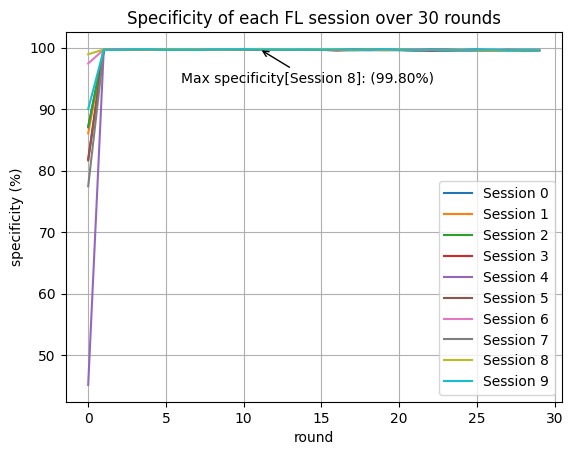

In [19]:
plot_all(p_histories)

### Plot Time Taken

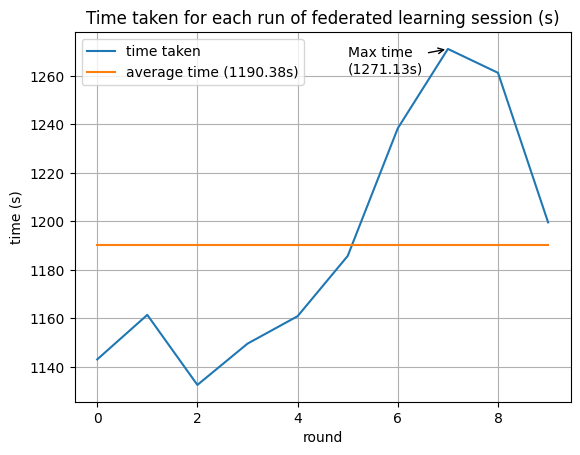

In [32]:
plt.figure('timetaken')
plt.title("Time taken for each run of federated learning session (s)")
avg = sum(times)/RUNS
max_t = max(times)
r = np.argmax(times) # Round number of the maximum
plt.plot(times, label='time taken')
plt.plot(np.full(shape=len(times), fill_value=(sum(times)/RUNS)), label=f'average time ({avg:.2f}s)')
plt.annotate(f'Max time \n({max_t:.2f}s)', xy=(r, max_t), xytext=(r-2, max_t-10), arrowprops=dict(arrowstyle='->', lw=1))
plt.xlabel('round')
plt.ylabel('time (s)')
plt.grid()
plt.legend()
plt.savefig(path.abspath(f"./figures/time_taken_sim_only.png"))

In [ ]:
import pickle
import os

def load_model(path: str):
    try:
        with open(path, 'rb') as file:
            return pickle.load(file)
    except IOError:
        print(f"Error loading file at {path}")
        return None
    
# prm = load_model(os.path.abspath("../../model_ckpt/model_r3.ckpt"))


## Hashing

In [ ]:
client_param = fl.common.parameters_to_ndarrays(param_storer)
bytes_client_param = b''.join(fl.common.parameter.ndarrays_to_parameters(client_param).tensors)
server_param = b''.join(param_storer.tensors)
# client_1.evaluate(, {})

In [ ]:
import numpy as np
import math

arr = np.arange(20)

def part(nc, cid, df, overlap):
    n = len(df)
    offset = overlap/2.0
    div_len = n // nc
    start = max(0, int(cid * div_len - (n * offset))) - 1
    print("Start:", start)
    end = min(n - 1, int(cid * div_len + (offset * n)))
    print("End:", end)
    return df[start:] if cid == nc else df[start:end]

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

sliding_window_view(arr, (1, 10), )

In [ ]:
nc = 3
part(nc, 1, arr, 0.5), part(nc, 2, arr, 0.5), part(nc, 3, arr, 0.5)